In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np 

D:\Anaconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [7]:
import numpy as np
import torch
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import scipy.linalg as slin
import scipy.sparse as sp
import networkx as nx
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import glob
import re
import math
from torch.optim.adam import Adam
from utils import *
from statistics import mean
import random

In [8]:
def simulate_random_dag(d: int,
                        degree: float,
                        w_range: tuple = (1.0, 1.0)) -> nx.DiGraph:
    """Simulate random DAG with an expected degree by Erdos-Renyi model.
        
        Args:
        d: number of nodes
        degree: expected node degree, in + out
        w_range: weight range +/- (low, high)
        
        Returns:
        G: weighted DAG
        """
    prob = float(degree) / (d - 1)
    B = np.tril((np.random.rand(d, d) < prob).astype(float), k=-1)
    
    # random permutation
    P = np.random.permutation(np.eye(d, d))  # permutes first axis only
    B_perm = P.T.dot(B).dot(P)
    U = np.random.uniform(low=w_range[0], high=w_range[1], size=[d, d])
    U[np.random.rand(d, d) < 0.5] *= -1
    W = (B_perm != 0).astype(float) * U
    
    # remove all in-edges (from precedent nodes) of the first node as A
    W[:, 0] = 0
    # remove all out-edges (from descendent nodes) of the last node as Y
    W[d-1, :] = 0
    # the remained nodes are the mediators M; and reset mediators if it has higher topological order than A or lower order than Y.
    ordered_vertices = list(nx.topological_sort(nx.DiGraph(W)))
    j = 1
    while j < d - 1:
        if  ordered_vertices.index(j) < ordered_vertices.index(0):
            W[j, 1:(d - 1)] = np.zeros (d - 2)
        if  ordered_vertices.index(j) > ordered_vertices.index(d - 1):
            W[1:(d - 1), j] = np.zeros (d - 2)
        j = j + 1
    #print("True weighted adjacency matrix B:\n", W)
    G = nx.DiGraph(W)
    calculate_effect(W)
    return W

In [9]:
np.random.seed(123456)
base_DAG=simulate_random_dag(5,4)
base_DAG

The total effect (TE): 0.0
The natural direct effect (DE): 0.0
The natural indirect effect (IE): 0.0
The natural direct effect for mediators (DM): [ 0.  0. -0.]
The natural direct effect for mediators (IM): [0. 0. 0.]


array([[ 0., -1., -0.,  1.,  0.],
       [ 0.,  0.,  0.,  0., -0.],
       [ 0.,  1., -0.,  0.,  1.],
       [ 0., -0.,  0.,  0., -0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [10]:
random.seed(1234567)
pick_element=random.sample(range(5), 2) ## pick two location to mutate
pick_1=np.nonzero(base_DAG)[0][pick_element[0]],np.nonzero(base_DAG)[1][pick_element[0]]
pick_2=np.nonzero(base_DAG)[0][pick_element[1]],np.nonzero(base_DAG)[1][pick_element[1]]

In [11]:
pick_1

(2, 4)

In [12]:
pick_2

(0, 3)

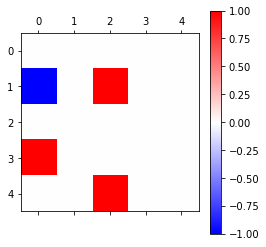

In [13]:
plt.matshow(base_DAG.T, cmap = 'bwr', vmin = -1, vmax = 1)
fig1 = plt.gcf()
plt.colorbar()
plt.show()

In [14]:
import math 
def cos(x):
    return ((math.cos(x/6*math.pi))/4+1)*0.8

In [15]:
def quadratic(x):
    return(-5+(10-x)**2)/200+0.5

In [16]:
def data_create(seed,time_stamp,set_graph):
  np.random.seed(seed)
  x = np.array(range(0, time_stamp))
  #y = np.array([cos(i)+np.random.normal(0, 0.1, 1) for i in x]) #generate coefficient
  y=np.array([cos(i) for i in x])
  z=np.array([quadratic(i) for i in x])##edited to have multiple
  base_DAG=set_graph 
  base_DAG[pick_1]=y[0]##edited to be coeffcient with error
  base_DAG[pick_2]=z[0]###multiple
  base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
  X_all = simulate_lsem(base_graph,30, 'Binary', 1,noise_scale=0.1)
  for i in range(1,time_stamp):
      base_DAG[pick_1]=y[i]##edited to be coeffcient with error
      base_DAG[pick_2]=z[i]###multiple
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      X = simulate_lsem(base_graph,30, 'Binary', 1,noise_scale=0.1)
      X_all=np.append(X_all,X,axis=0)
      print(base_DAG)
  return X_all

## piecewise ANOCA

In [17]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import pickle
import os
import random

import torch.optim as optim
from torch.optim import lr_scheduler
import math
from utils import *

from multiprocessing import Pool
import multiprocessing
n_cores = multiprocessing.cpu_count()
from numpy.random import randn
from random import seed as rseed
from numpy.random import seed as npseed


In [18]:
# compute constraint h(A) value
def _h_A(A, m):
    expm_A = matrix_poly(A*A, m)
    h_A = torch.trace(expm_A) - m
    return h_A

prox_plus = torch.nn.Threshold(0.,0.)

def stau(w, tau):
    w1 = prox_plus(torch.abs(w)-tau)
    return torch.sign(w)*w1


def update_optimizer(optimizer, original_lr, c_A):
    '''related LR to c_A, whenever c_A gets big, reduce LR proportionally'''
    MAX_LR = 1e-2
    MIN_LR = 1e-4

    estimated_lr = original_lr / (math.log10(c_A) + 1e-10)
    if estimated_lr > MAX_LR:
        lr = MAX_LR
    elif estimated_lr < MIN_LR:
        lr = MIN_LR
    else:
        lr = estimated_lr

    # set LR
    for parame_group in optimizer.param_groups:
        parame_group['lr'] = lr

    return optimizer, lr

#===================================
# training:
#===================================

def train(epoch, lambda_A, c_A, optimizer,old_lr):
    t = time.time()
    nll_train = []
    kl_train = []
    mse_train = []
    shd_trian = []

    encoder.train()
    decoder.train()
    scheduler.step()


    # update optimizer
    optimizer, lr = update_optimizer(optimizer, old_lr, c_A)


    for batch_idx, (data, relations) in enumerate(train_loader):

#         if args.cuda:
#             data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data).double(), Variable(relations).double()

        # reshape data
        relations = relations.unsqueeze(2)

        optimizer.zero_grad()

        enc_x, logits, origin_A, adj_A_tilt_encoder, z_gap, z_positive, myA, Wa = encoder(data, rel_rec, rel_send)  # logits is of size: [num_sims, z_dims]
        edges = logits

        dec_x, output, adj_A_tilt_decoder = decoder(data, edges,d * x_dims, rel_rec, rel_send, origin_A, adj_A_tilt_encoder, Wa)

        if torch.sum(output != output):
            print('nan error\n')

        target = data
        preds = output
        variance = 0.

        # reconstruction accuracy loss
        loss_nll = nll_gaussian(preds, target, variance)

        # KL loss
        loss_kl = kl_gaussian(logits)

        # ELBO loss:
        loss = loss_kl + loss_nll

        # add A loss
        one_adj_A = origin_A # torch.mean(adj_A_tilt_decoder, dim =0)
        sparse_loss = tau_A * torch.sum(torch.abs(one_adj_A))

        # compute h(A)
        h_A = _h_A(origin_A, d)
        loss += lambda_A * h_A + 0.5 * c_A * h_A * h_A + 100. * torch.trace(origin_A*origin_A) + sparse_loss #+  0.01 * torch.sum(variance * variance)


        loss.backward()
        loss = optimizer.step()

        myA.data = stau(myA.data, tau_A*lr)


        mse_train.append(F.mse_loss(preds, target).item())
        nll_train.append(loss_nll.item())
        kl_train.append(loss_kl.item())

    #print(h_A.item())

    return np.mean(np.mean(kl_train)  + np.mean(nll_train)), np.mean(nll_train), np.mean(mse_train), origin_A, optimizer, lr



In [19]:
n = 30 # The number of samples of data.
d = 5 # The number of variables in data.
x_dims = 1 # The number of input dimensions: default 1.
z_dims = d # The number of latent variable dimensions: default the same as variable size.
epochs = 200 # Number of epochs to train.
batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.
n_var=5

n_times=30 #no. of replicates
time_stamp=10 #no. of timestamp
np.random.seed(1234567) #Random seed
seed_list=np.random.randint(1, 1000000, size=n_times)
average_coef_list=np.zeros((n_times,time_stamp,n_var,n_var))
B_list=np.zeros((n_times,d, d))
FDR_total=[]
TPR_total=[]
SHD_total=[]
time_list=[]
for replicate in range(n_times):
  seed=seed_list[replicate]
  X_all=data_create(seed,time_stamp,base_DAG) #create data
  average_list=np.zeros((time_stamp,d, d))
  FDR_list_piece=[]
  TPR_list_piece=[]
  SHD_list_piece=[]
  base_DAG=np.zeros((5, 5))
  ####estimate at each time_stamp####
  timestart=time.time()
  for j in range(time_stamp):
  # ----------- Configurations:
      k_max_iter = int(1e2) # The max iteration number for searching parameters.
      original_lr = 3e-3  # Initial learning rate.
      encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
      decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
      temp = 0.5 # Temperature for Gumbel softmax.
      factor = True # Factor graph model.
      encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
      decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
      tau_A = 0. # Coefficient for L-1 norm of matrix B.
      lambda1 = 0. # Coefficient for DAG constraint h1(B).
      c_B = 1 # Coefficient for absolute value h1(B).
      h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
      lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
      gamma = 1.0 # LR decay factor. 
      ######################


      X=X_all[(j*30):(j*30+30),:]


      np.random.seed(seed)
      random.seed(seed)
      torch.manual_seed(seed)
      feat_train = torch.FloatTensor(X)
      feat_valid = torch.FloatTensor(X)
      feat_test = torch.FloatTensor(X)

      # Reconstruct itself
      train_data = TensorDataset(feat_train, feat_train)
      valid_data = TensorDataset(feat_valid, feat_train)
      test_data = TensorDataset(feat_test, feat_train)

      train_loader = DataLoader(train_data, batch_size = batch_size)
      valid_loader = DataLoader(valid_data, batch_size = batch_size)
      test_loader = DataLoader(test_data, batch_size = batch_size)

      # ----------- Load modules:
      off_diag = np.ones([d, d]) - np.eye(d) # Generate off-diagonal interaction graph
      rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype = np.float64)
      rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype = np.float64)
      rel_rec = torch.DoubleTensor(rel_rec)
      rel_send = torch.DoubleTensor(rel_send)
      adj_A = np.zeros((d, d)) # Add adjacency matrix

      encoder = MLPEncoder(d * x_dims, x_dims, encoder_hidden,
                              int(z_dims), adj_A,
                              batch_size = batch_size,
                              do_prob = encoder_dropout, factor = factor).double()
      decoder = MLPDecoder(d * x_dims,
                              z_dims, x_dims, encoder,
                              data_variable_size = d,
                              batch_size = batch_size,
                              n_hid=decoder_hidden,
                              do_prob=decoder_dropout).double()

      # ----------- Set up optimizer:
      optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = original_lr)
      scheduler = lr_scheduler.StepLR(optimizer, step_size = lr_decay,
                                      gamma = gamma)

      rel_rec = Variable(rel_rec)
      rel_send = Variable(rel_send)

      # ----------- Main:
      best_ELBO_loss = np.inf
      best_NLL_loss = np.inf
      best_MSE_loss = np.inf
      h1_B_new = torch.tensor(1.)
      h2_B_new = 1
      h1_B_old = np.inf
      h2_B_old = np.inf
      lr = original_lr
    

      try:
          for step_k in range(k_max_iter):
              while c_B< 1e+20:
                  for epoch in range(epochs):
                      old_lr = lr 
                      ELBO_loss, NLL_loss, MSE_loss, origin_B, optimizer, lr = train(epoch, lambda1, c_B, optimizer, old_lr)

                      if ELBO_loss < best_ELBO_loss:
                          best_ELBO_loss = ELBO_loss

                      if NLL_loss < best_NLL_loss:
                          best_NLL_loss = NLL_loss

                      if MSE_loss < best_MSE_loss:
                          best_MSE_loss = MSE_loss

                  if ELBO_loss > 2 * best_ELBO_loss:
                      break

                  # Update parameters
                  B_new = origin_B.data.clone()
                  h1_B_new =  _h_A(B_new,d)
                  if h1_B_new.item() > 0.25 * h1_B_old:
                      c_B *= 10
                  else:
                      break

              # Update parameters    
              h1_B_old = h1_B_new.item()
              lambda1 += c_B * h1_B_new.item()

              if h1_B_new.item() <= h1_tol:
                  break

      except KeyboardInterrupt:
          print('KeyboardInterrupt')

      predB = np.matrix(origin_B.data.clone().numpy())
      print('Best ELBO Loss :', best_ELBO_loss)
      print('Best NLL Loss :', best_NLL_loss)
      print('Best MSE Loss :', best_MSE_loss)
      #calculate_effect(predB)
      print(j)
      average_list[j,:,:]=predB



  average_coef_list[replicate,:,:,:]=average_list #average coef save to matrix
  np.save("S2_10_30_DAGGNN",average_coef_list)
#   timeend=time.time()
#   time_list.append(timeend-timestart)
  #print(timeend-timestart)
  #####write at every epoch
  #df.to_csv("cos_rep10.csv")
  print(replicate)

[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.         -0.          0.6         0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.     

D:\Anaconda\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Best ELBO Loss : 0.0012259653207082823
Best NLL Loss : 1.4240243147233873e-06
Best MSE Loss : 5.696097258893549e-07
0
Best ELBO Loss : 0.0006245447558166666
Best NLL Loss : 6.440015763929013e-07
Best MSE Loss : 2.576006305571605e-07
1
Best ELBO Loss : 0.0007246655565521592
Best NLL Loss : 8.604249145218427e-07
Best MSE Loss : 3.4416996580873713e-07
2
Best ELBO Loss : 0.0008209163634541432
Best NLL Loss : 1.589487756959428e-06
Best MSE Loss : 6.357951027837712e-07
3
Best ELBO Loss : 0.0006443465808310891
Best NLL Loss : 1.0172444045592977e-06
Best MSE Loss : 4.0689776182371906e-07
4
Best ELBO Loss : 0.00047790822830506564
Best NLL Loss : 1.963081516206036e-07
Best MSE Loss : 7.852326064824143e-08
5
Best ELBO Loss : 0.0005434327549256233
Best NLL Loss : 3.227377339025943e-07
Best MSE Loss : 1.290950935610377e-07
6
Best ELBO Loss : 0.000654306800667792
Best NLL Loss : 6.789975677856845e-07
Best MSE Loss : 2.7159902711427384e-07
7
Best ELBO Loss : 0.0005850936771864535
Best NLL Loss : 7.47

Best ELBO Loss : 0.0015248744080480752
Best NLL Loss : 2.5277362622553393e-06
Best MSE Loss : 1.0110945049021357e-06
0
Best ELBO Loss : 0.0010724940558173076
Best NLL Loss : 1.992819674779446e-06
Best MSE Loss : 7.971278699117785e-07
1
Best ELBO Loss : 0.0010249732088311067
Best NLL Loss : 1.7538669084808056e-06
Best MSE Loss : 7.015467633923223e-07
2
Best ELBO Loss : 0.0012114785333922629
Best NLL Loss : 3.9729955715885905e-06
Best MSE Loss : 1.5891982286354362e-06
3
Best ELBO Loss : 0.001072161724130062
Best NLL Loss : 1.3062214890569094e-06
Best MSE Loss : 5.224885956227638e-07
4
Best ELBO Loss : 0.0009146657992671006
Best NLL Loss : 1.2154304760175997e-06
Best MSE Loss : 4.861721904070399e-07
5
Best ELBO Loss : 0.0010915135982109254
Best NLL Loss : 9.031056790279158e-07
Best MSE Loss : 3.6124227161116636e-07
6
Best ELBO Loss : 0.0008702328328117987
Best NLL Loss : 1.3795375530181939e-06
Best MSE Loss : 5.518150212072775e-07
7
Best ELBO Loss : 0.000896741581712925
Best NLL Loss : 8.

Best ELBO Loss : 0.001147695175008395
Best NLL Loss : 1.5283472987053187e-06
Best MSE Loss : 6.113389194821275e-07
0
Best ELBO Loss : 0.0007086603107870721
Best NLL Loss : 8.607465858334626e-07
Best MSE Loss : 3.442986343333851e-07
1
Best ELBO Loss : 0.0006961691293568876
Best NLL Loss : 5.567482531273563e-07
Best MSE Loss : 2.2269930125094252e-07
2
Best ELBO Loss : 0.000680892655298339
Best NLL Loss : 4.932225917243106e-07
Best MSE Loss : 1.9728903668972422e-07
3
Best ELBO Loss : 0.000510999461821785
Best NLL Loss : 5.036512192431466e-07
Best MSE Loss : 2.0146048769725862e-07
4
Best ELBO Loss : 0.0006639112723633216
Best NLL Loss : 6.420311500422432e-07
Best MSE Loss : 2.568124600168973e-07
5
Best ELBO Loss : 0.0007118842614582394
Best NLL Loss : 4.275132593290975e-07
Best MSE Loss : 1.7100530373163898e-07
6
Best ELBO Loss : 0.00048707033278835496
Best NLL Loss : 3.253588933969295e-07
Best MSE Loss : 1.3014355735877177e-07
7
Best ELBO Loss : 0.0006574179394029928
Best NLL Loss : 6.877

Best ELBO Loss : 0.0011864164633401879
Best NLL Loss : 1.230279932450625e-06
Best MSE Loss : 4.9211197298025e-07
0
Best ELBO Loss : 0.0009594624245622663
Best NLL Loss : 8.77377343637347e-07
Best MSE Loss : 3.509509374549388e-07
1
Best ELBO Loss : 0.0008218215678594346
Best NLL Loss : 6.45660323612643e-07
Best MSE Loss : 2.582641294450572e-07
2
Best ELBO Loss : 0.000954523367531142
Best NLL Loss : 9.94258575672711e-07
Best MSE Loss : 3.977034302690844e-07
3
Best ELBO Loss : 0.0008097149028111771
Best NLL Loss : 3.5606282847811766e-07
Best MSE Loss : 1.424251313912471e-07
4
Best ELBO Loss : 0.0008087326999340097
Best NLL Loss : 8.301481373647926e-07
Best MSE Loss : 3.32059254945917e-07
5
Best ELBO Loss : 0.0007228173844348195
Best NLL Loss : 5.556270081936843e-07
Best MSE Loss : 2.2225080327747375e-07
6
Best ELBO Loss : 0.0006819276107680348
Best NLL Loss : 3.707449197457059e-07
Best MSE Loss : 1.4829796789828234e-07
7
Best ELBO Loss : 0.0007012263687152583
Best NLL Loss : 7.35195651058

Best ELBO Loss : 0.0018959872502805541
Best NLL Loss : 3.3700094963342257e-06
Best MSE Loss : 1.3480037985336903e-06
0
Best ELBO Loss : 0.0013682009922085583
Best NLL Loss : 2.2121394950040825e-06
Best MSE Loss : 8.848557980016329e-07
1
Best ELBO Loss : 0.0010370943030161776
Best NLL Loss : 1.433729174960672e-06
Best MSE Loss : 5.734916699842688e-07
2
Best ELBO Loss : 0.0014456350183117222
Best NLL Loss : 2.9000866023813286e-06
Best MSE Loss : 1.1600346409525313e-06
3
Best ELBO Loss : 0.0012513700619251533
Best NLL Loss : 1.766633065310961e-06
Best MSE Loss : 7.066532261243845e-07
4
Best ELBO Loss : 0.0012909898959153386
Best NLL Loss : 1.256791430049824e-06
Best MSE Loss : 5.027165720199296e-07
5
Best ELBO Loss : 0.0010802660381771206
Best NLL Loss : 1.3113140358385684e-06
Best MSE Loss : 5.245256143354275e-07
6
Best ELBO Loss : 0.0011518874212305661
Best NLL Loss : 2.2493583206019406e-06
Best MSE Loss : 8.997433282407763e-07
7
Best ELBO Loss : 0.0015389015009611257
Best NLL Loss : 3.

Best ELBO Loss : 0.0015469292200436286
Best NLL Loss : 1.5431328231183356e-06
Best MSE Loss : 6.172531292473343e-07
0
Best ELBO Loss : 0.0008325369279592598
Best NLL Loss : 9.368139187831815e-07
Best MSE Loss : 3.747255675132726e-07
1
Best ELBO Loss : 0.0009525048526548161
Best NLL Loss : 1.2572752014440443e-06
Best MSE Loss : 5.029100805776176e-07
2
Best ELBO Loss : 0.0007856085647220608
Best NLL Loss : 1.5622567377449565e-06
Best MSE Loss : 6.249026950979826e-07
3
Best ELBO Loss : 0.0006880388099585693
Best NLL Loss : 1.5164440110224962e-06
Best MSE Loss : 6.065776044089984e-07
4
Best ELBO Loss : 0.0008556095683238274
Best NLL Loss : 1.1053525210635307e-06
Best MSE Loss : 4.4214100842541226e-07
5
Best ELBO Loss : 0.0007409300120223846
Best NLL Loss : 3.616438730300664e-07
Best MSE Loss : 1.4465754921202656e-07
6
Best ELBO Loss : 0.0006701198188382296
Best NLL Loss : 5.422040507946826e-07
Best MSE Loss : 2.1688162031787304e-07
7
Best ELBO Loss : 0.000655415855797946
Best NLL Loss : 5.

Best ELBO Loss : 0.0010798793186674576
Best NLL Loss : 4.945120270542904e-07
Best MSE Loss : 1.9780481082171618e-07
0
Best ELBO Loss : 0.0010530889161709577
Best NLL Loss : 1.1091073212895863e-06
Best MSE Loss : 4.436429285158345e-07
1
Best ELBO Loss : 0.0009568333578436654
Best NLL Loss : 9.794384722707375e-07
Best MSE Loss : 3.9177538890829506e-07
2
Best ELBO Loss : 0.0007458351499078374
Best NLL Loss : 7.072222138662867e-07
Best MSE Loss : 2.8288888554651465e-07
3
Best ELBO Loss : 0.0008816558334079612
Best NLL Loss : 8.527913376562058e-07
Best MSE Loss : 3.4111653506248234e-07
4
Best ELBO Loss : 0.0007479318770600614
Best NLL Loss : 6.349324190121722e-07
Best MSE Loss : 2.5397296760486893e-07
5
Best ELBO Loss : 0.0007638302229361239
Best NLL Loss : 6.42894661175986e-07
Best MSE Loss : 2.571578644703944e-07
6
Best ELBO Loss : 0.0007576558154224252
Best NLL Loss : 2.6631970736564534e-07
Best MSE Loss : 1.0652788294625813e-07
7
Best ELBO Loss : 0.0006442574257200027
Best NLL Loss : 2.

Best ELBO Loss : 0.0009152648048497997
Best NLL Loss : 7.911416897214453e-07
Best MSE Loss : 3.164566758885781e-07
0
Best ELBO Loss : 0.0007779197284544963
Best NLL Loss : 4.856915547373083e-07
Best MSE Loss : 1.9427662189492333e-07
1
Best ELBO Loss : 0.0007505295415059477
Best NLL Loss : 7.636571733826746e-06
Best MSE Loss : 3.054628693530699e-06
2
Best ELBO Loss : 0.0006987625591319469
Best NLL Loss : 6.275412761911446e-07
Best MSE Loss : 2.5101651047645786e-07
3
Best ELBO Loss : 0.000712947265352575
Best NLL Loss : 8.063786171277879e-07
Best MSE Loss : 3.2255144685111516e-07
4
Best ELBO Loss : 0.0006354897102343297
Best NLL Loss : 6.532165526203964e-07
Best MSE Loss : 2.6128662104815854e-07
5
Best ELBO Loss : 0.0005959906655562458
Best NLL Loss : 6.75842805752674e-07
Best MSE Loss : 2.7033712230106956e-07
6
Best ELBO Loss : 0.0006396622648048196
Best NLL Loss : 5.681615092258955e-07
Best MSE Loss : 2.272646036903582e-07
7
Best ELBO Loss : 0.0004824953893929601
Best NLL Loss : 5.6118

Best ELBO Loss : 0.0012686070006447108
Best NLL Loss : 2.6172147024839348e-06
Best MSE Loss : 1.0468858809935738e-06
0
Best ELBO Loss : 0.0011235489255947782
Best NLL Loss : 2.46267576626241e-06
Best MSE Loss : 9.85070306504964e-07
1
Best ELBO Loss : 0.0013716970030485658
Best NLL Loss : 2.7180311021367963e-06
Best MSE Loss : 1.0872124408547189e-06
2
Best ELBO Loss : 0.0011342178322241
Best NLL Loss : 1.96405717537998e-06
Best MSE Loss : 7.85622870151992e-07
3
Best ELBO Loss : 0.0009694369551795388
Best NLL Loss : 1.255894179295604e-06
Best MSE Loss : 5.023576717182415e-07
4
Best ELBO Loss : 0.000964938773483689
Best NLL Loss : 9.216210098797873e-07
Best MSE Loss : 3.6864840395191483e-07
5
Best ELBO Loss : 0.00092371122448898
Best NLL Loss : 7.218367612905215e-07
Best MSE Loss : 2.887347045162086e-07
6
Best ELBO Loss : 0.0010001154771144523
Best NLL Loss : 2.0840354941595726e-06
Best MSE Loss : 8.33614197663829e-07
7
Best ELBO Loss : 0.0008905811857644643
Best NLL Loss : 2.338658198627

Best ELBO Loss : 0.0008932630787303521
Best NLL Loss : 1.964670393942801e-06
Best MSE Loss : 7.858681575771207e-07
0
Best ELBO Loss : 0.0009508278330426444
Best NLL Loss : 1.2438166204549308e-06
Best MSE Loss : 4.975266481819723e-07
1
Best ELBO Loss : 0.0007255543737743494
Best NLL Loss : 9.561201241088336e-07
Best MSE Loss : 3.8244804964353334e-07
2
Best ELBO Loss : 0.001159243790581364
Best NLL Loss : 1.3661467878937664e-06
Best MSE Loss : 5.464587151575066e-07
3
Best ELBO Loss : 0.0007593937384221002
Best NLL Loss : 9.244492144790378e-07
Best MSE Loss : 3.697796857916151e-07
4
Best ELBO Loss : 0.0011135955161966293
Best NLL Loss : 2.543879385017724e-06
Best MSE Loss : 1.01755175400709e-06
5
Best ELBO Loss : 0.0008799739001377964
Best NLL Loss : 8.274223034470446e-07
Best MSE Loss : 3.3096892137881787e-07
6
Best ELBO Loss : 0.0008612206360576554
Best NLL Loss : 1.4943640082072657e-06
Best MSE Loss : 5.977456032829062e-07
7
Best ELBO Loss : 0.0006630481932905364
Best NLL Loss : 8.5547